<a href="https://colab.research.google.com/github/martinpius/Applied-Predictive-Modeling2/blob/master/Sparks_Recarp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are using colab with tensorflow version: {tf.__version__}")
except Exception as e:
  COLAB = False
  print(f"The error is: {type(e)}: {e}\n....Please Load Your Drive....")

def time_fmt(x):
  h = int(x / (60 * 60))
  m = int(x % (60 * 60) / 60)
  s = int(x % 60)
  return f"{h}: {m:>03}: {s:>05.2f}"

print(f"Time elapse is : {time_fmt(123.56309)}")

Mounted at /content/drive
You are using colab with tensorflow version: 2.4.0
Time elapse is : 0: 002: 03.00


In [38]:
#The simple Inception net from scratch!!!

In [42]:
import tensorflow as tf
import time
import numpy as np

In [40]:
inputs = tf.keras.Input(shape = (32, 32, 3), name = 'cifar10_img')
x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'same',activation = 'relu', name = 'conv1')(inputs)
x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding = 'same', activation = 'relu', name = 'conv2')(x)
out1 = tf.keras.layers.MaxPooling2D(pool_size = 3, name = 'max_pool')(x)

x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'conv3')(out1)
x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', name = 'conv4')(x)
block1 = tf.keras.layers.concatenate([x, out1])

x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', name = 'conv5')(block1)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same',name = 'conv6')(x)
block2 =  tf.keras.layers.concatenate([x, block1])

x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', name = 'conv7')(block2)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same',name = 'conv8')(x)
block3 =  tf.keras.layers.concatenate([x, block2])

x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'valid', name = 'conv9')(block3)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'valid', name = 'conv10')(x)
x = tf.keras.layers.GlobalMaxPool2D(name = 'global_max_pool')(x)
x = tf.keras.layers.BatchNormalization(name = 'batch_norm')(x)
x = tf.keras.layers.Dropout(rate = 0.5, name = 'dropout')(x)
outputs = tf.keras.layers.Dense(units = 10, kernel_initializer = 'random_normal', activation = 'softmax', name = 'output')(x)

In [41]:
model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'inception')

Model: "inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cifar10_img (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 128)  3584        cifar10_img[0][0]                
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 16, 16, 64)   73792       conv1[0][0]                      
__________________________________________________________________________________________________
max_pool (MaxPooling2D)         (None, 5, 5, 64)     0           conv2[0][0]                      
__________________________________________________________________________________________

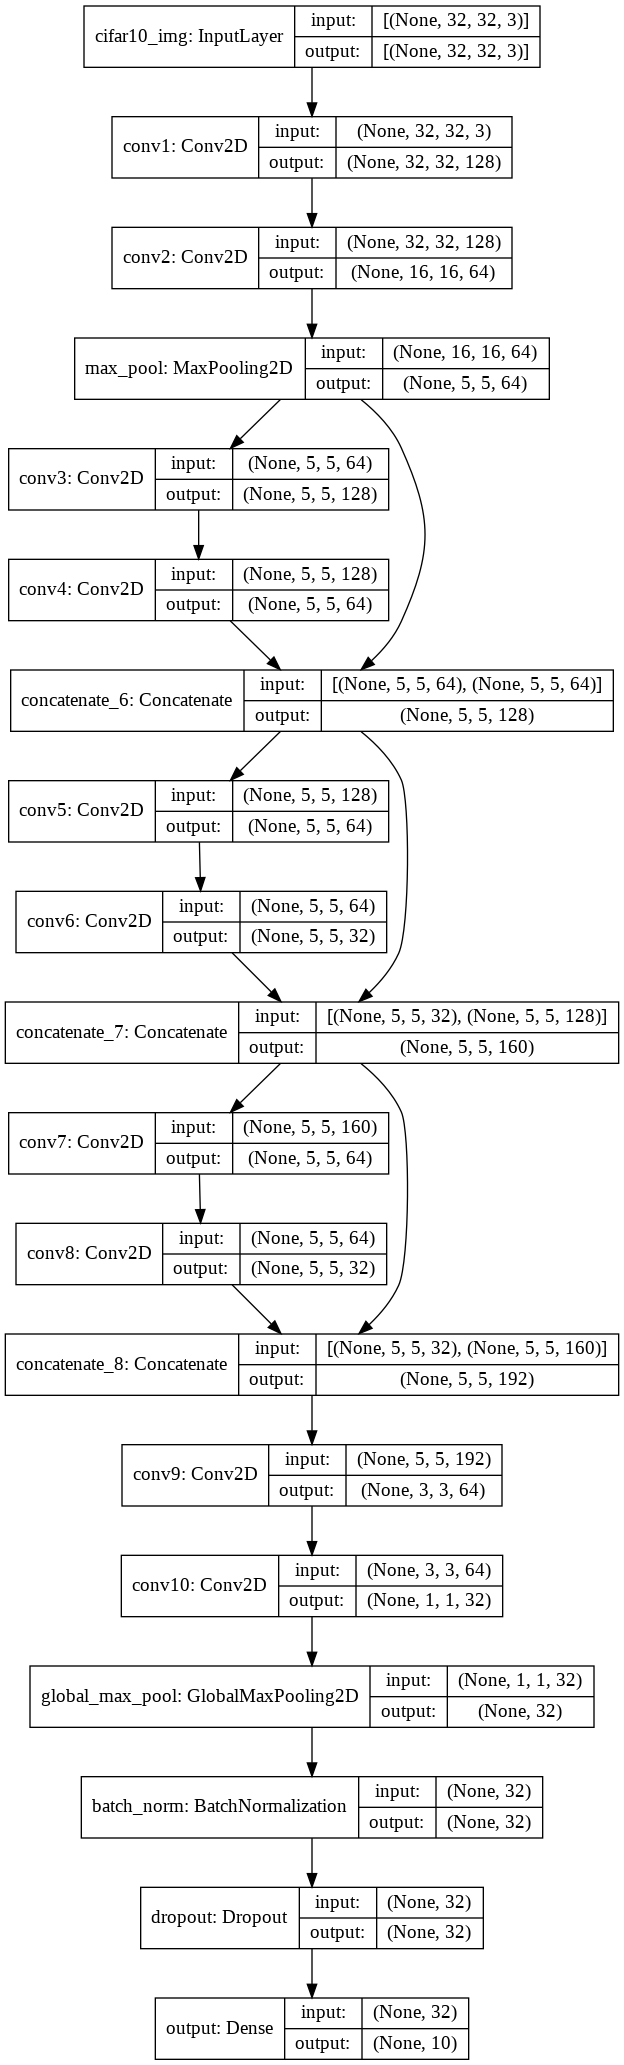

In [42]:
model.summary()
tf.keras.utils.plot_model(model = model, to_file = 'inception.png', show_shapes = True)

In [43]:
#Training from scatch!
#Getting the data from keras
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()

In [44]:
print(f"x_train_shape: {x_train.shape}, y_train_shape: {y_train.shape}\nx_test_shape: {x_test.shape}, y_test_shape: {y_test.shape}")

x_train_shape: (50000, 32, 32, 3), y_train_shape: (50000, 1)
x_test_shape: (10000, 32, 32, 3), y_test_shape: (10000, 1)


In [45]:
y_train, y_test = tf.keras.utils.to_categorical(y_train, num_classes = 10), tf.keras.utils.to_categorical(y_test, num_classes = 10)

In [46]:
assert [y_train.shape, y_test.shape] == [(50000,10), (10000,10)]

In [47]:
#Convert to tensorflow data:
BUFFER = len(x_train)
BATCH_SIZE = 64
steps_per_epochs_train = BUFFER//BATCH_SIZE


In [48]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(BUFFER).batch(BATCH_SIZE, drop_remainder = True)
val_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_data = val_data.shuffle(BUFFER).batch(BATCH_SIZE, drop_remainder = True)


In [49]:
#Get the sample training batch

In [50]:
sample_x_train_batch, sample_y_train_batch = next(iter(train_data))

In [51]:
print(f"sample_x_train_batch_shape: {sample_x_train_batch.shape}\nsample_train_y_batch: {sample_y_train_batch.shape}")

sample_x_train_batch_shape: (64, 32, 32, 3)
sample_train_y_batch: (64, 10)


In [52]:
#The training loop :
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-3)
metric_fn = tf.keras.metrics.CategoricalAccuracy()
val_metric = tf.keras.metrics.CategoricalAccuracy()

In [53]:
epochs = 20
tic = time.time()
for epoch in range(epochs):
  print(f"The begining of epoch: {epoch + 1}: ")
  for (step, (input, output)) in enumerate(train_data):
    with tf.GradientTape() as tape:
      preds = model(input,training= True)
      t_loss = loss_fn(output,preds)
    grads = tape.gradient(t_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    metric_fn.update_state(output, preds)
    train_accuracy = metric_fn.result()
    metric_fn.reset_states()
    if step % 100 == 0:
      print(f"At epoch: {epoch + 1}: Batch: {step}: training loss is : {float(t_loss):.4f}: training accuracy is: {float(train_accuracy):.2f}")
  
  for (step, (input, output)) in enumerate(val_data):
    preds = model(input, training = False)
    val_loss = loss_fn(output, preds)
    val_metric.update_state(output, preds)
    val_accuracy = val_metric.result()
    val_metric.reset_states()
    if step % 200 == 0:
      print(f"Validation accuracy: {val_accuracy:.4f}")

toc = time.time()
print(f"time elapse: {time_fmt(toc - tic)}")   
  



    



The begining of epoch: 1: 
At epoch: 1: Batch: 0: training loss is : 2.3755: training accuracy is: 0.11
At epoch: 1: Batch: 100: training loss is : 1.9707: training accuracy is: 0.31
At epoch: 1: Batch: 200: training loss is : 1.8161: training accuracy is: 0.30
At epoch: 1: Batch: 300: training loss is : 1.6148: training accuracy is: 0.50
At epoch: 1: Batch: 400: training loss is : 1.6696: training accuracy is: 0.47
At epoch: 1: Batch: 500: training loss is : 1.2959: training accuracy is: 0.58
At epoch: 1: Batch: 600: training loss is : 1.4061: training accuracy is: 0.55
At epoch: 1: Batch: 700: training loss is : 1.5007: training accuracy is: 0.36
Validation accuracy: 0.6094
The begining of epoch: 2: 
At epoch: 2: Batch: 0: training loss is : 1.4306: training accuracy is: 0.45
At epoch: 2: Batch: 100: training loss is : 1.0956: training accuracy is: 0.64
At epoch: 2: Batch: 200: training loss is : 1.2762: training accuracy is: 0.58
At epoch: 2: Batch: 300: training loss is : 1.1910: t

In [54]:
 print(f"time elapse: {time_fmt(time.time() - tic)}")

time elapse: 0: 010: 06.00


In [1]:
#Model subclassing....Build the same model 

In [43]:
class Dense_layer(tf.keras.layers.Layer):
  def __init__(self, units = 64, name = 'dense_layer', **kwargs):
    super(Dense_layer, self).__init__(name = name, **kwargs)
    self.units = units
  
  def build(self, inputs_dim):
    self.w = self.add_weight(shape = (inputs_dim[-1], self.units), trainable = True, initializer = 'random_normal', name = 'weights')
    self.b = self.add_weight(shape = (self.units, ), trainable = True, initializer = 'zeros', name = 'bias')
  
  def call(self, inputs):
    out = tf.matmul(inputs, self.w) + self.b
    return tf.nn.relu(out)

In [44]:
dense_layer = Dense_layer(units = 10,name = 'dense')

In [45]:
output = dense_layer(tf.keras.Input(shape = (3,)))

In [46]:
output

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>

In [64]:
inputs = tf.keras.Input(shape = (784,), name = 'mnist_mlp')
x = tf.keras.layers.Dense(units = 1024, kernel_initializer = 'random_normal', activation = 'relu', name = 'dense1')(inputs)
x = tf.keras.layers.Dense(units = 512, kernel_initializer = 'random_normal', activation = 'relu', name = 'dense2')(x)
x = tf.keras.layers.Dropout(rate = 0.5, name = 'drop_out')(x)
outputs = tf.keras.layers.Dense(units = 10, activation = 'softmax', kernel_initializer = 'random_normal', name = 'output')(x)
mlp_mnist = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'mlp_mnist')

Model: "mlp_mnist"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mnist_mlp (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
dense1 (Dense)               (None, 1024)              803840    
_________________________________________________________________
dense2 (Dense)               (None, 512)               524800    
_________________________________________________________________
drop_out (Dropout)           (None, 512)               0         
_________________________________________________________________
output (Dense)               (None, 10)                5130      
Total params: 1,333,770
Trainable params: 1,333,770
Non-trainable params: 0
_________________________________________________________________


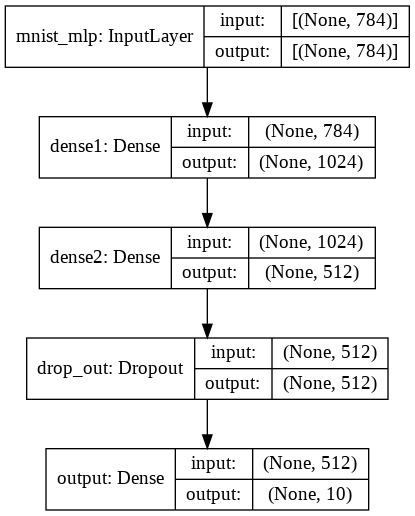

In [65]:
mlp_mnist.summary()
tf.keras.utils.plot_model(model = mlp_mnist, to_file = "mlp_cifar10.png", show_shapes = True)

In [66]:
#Load the data.
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [67]:
print(f"x_train_shape: {x_train.shape}, y_train_shape: {y_train.shape}\nx_test_shape: {x_test.shape}, y_test_shape: {y_test.shape}")

x_train_shape: (60000, 28, 28), y_train_shape: (60000,)
x_test_shape: (10000, 28, 28), y_test_shape: (10000,)


In [68]:
x_train, x_test = x_train.reshape(60000,784).astype('float32')/255.0, x_test.reshape(10000, 784).astype('float32')/255.0

In [69]:
print(f"x_train_shape: {x_train.shape}, x_test_shape: {x_test.shape}")

x_train_shape: (60000, 784), x_test_shape: (10000, 784)


In [70]:
y_train, y_test = tf.keras.utils.to_categorical(y_train, num_classes = 10), tf.keras.utils.to_categorical(y_test, num_classes = 10)

In [71]:
print(f"y_train_shape: {y_train.shape}, y_test_shape: {y_test.shape}")

y_train_shape: (60000, 10), y_test_shape: (10000, 10)


In [72]:
BATCH_SIZE = 64
BUFFER = len(x_train)
train_dfm = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dfm = train_dfm.shuffle(BUFFER).batch(BATCH_SIZE, drop_remainder = True)
val_dfm = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dfm = val_dfm.shuffle(BUFFER).batch(BATCH_SIZE, drop_remainder = True)

In [73]:
sample_x_train_batch, sample_y_train_batch = next(iter(train_dfm))

In [74]:
print(f"sample_x_train_shape: {sample_x_train_batch.shape}, sample_y_train_batch: {sample_y_train_batch.shape}")

sample_x_train_shape: (64, 784), sample_y_train_batch: (64, 10)


In [75]:
#Get the loss, optimizer and metrics

In [79]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
metric_fn = tf.keras.metrics.CategoricalAccuracy()
val_metric = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)


In [80]:
#The train step/loop from scratch.

In [81]:
epochs = 20
tic = time.time()
#Looping over the epochs:
for epoch in range(epochs):
  print(f"The start of epoch: {epoch + 1}")
  #Iterate over the batches:
  for (step, (input, output)) in enumerate(train_dfm):
    with tf.GradientTape() as tape:
      preds = mlp_mnist(input, training = True)
      loss = loss_fn(preds, output)
    grads = tape.gradient(loss, mlp_mnist.trainable_weights)
    optimizer.apply_gradients(zip(grads, mlp_mnist.trainable_weights))
    metric_fn.update_state(preds, output)
    train_accuracy = metric_fn.result()
    metric_fn.reset_states()
    if step % 100 == 0:
      print(f"epoch: {epoch +1}: batch number: {step}: train_loss: {loss:.4f}: train accuracy: {train_accuracy:.4f}")
  
  for (step, (input, output)) in enumerate(val_dfm):
    preds = mlp_mnist(input,training = False)
    val_loss = loss_fn(preds, output)
    val_metric.update_state(preds, output)
    val_accuracy = val_metric.result()
    val_metric.reset_states()

    if step % 100 == 0:
      print(f"epoch: {epoch + 1}: validation loss: {val_loss:.4f}: validation accuracy: {val_accuracy:.4f}")

toc = time.time()
print(f"time elapse is : {time_fmt(toc - tic)}")


The start of epoch: 1
epoch: 1: batch number: 0: train_loss: 1.2665: train accuracy: 0.9375
epoch: 1: batch number: 100: train_loss: 0.9608: train accuracy: 0.9375
epoch: 1: batch number: 200: train_loss: 1.3805: train accuracy: 0.9219
epoch: 1: batch number: 300: train_loss: 0.9287: train accuracy: 0.9531
epoch: 1: batch number: 400: train_loss: 0.6737: train accuracy: 0.9688
epoch: 1: batch number: 500: train_loss: 0.2977: train accuracy: 0.9844
epoch: 1: batch number: 600: train_loss: 1.4560: train accuracy: 0.9219
epoch: 1: batch number: 700: train_loss: 0.8824: train accuracy: 0.9531
epoch: 1: batch number: 800: train_loss: 1.1892: train accuracy: 0.9219
epoch: 1: batch number: 900: train_loss: 0.7507: train accuracy: 0.9531
epoch: 1: validation loss: 0.4319: validation accuracy: 0.9688
epoch: 1: validation loss: 0.6866: validation accuracy: 0.9688
The start of epoch: 2
epoch: 2: batch number: 0: train_loss: 0.0840: train accuracy: 1.0000
epoch: 2: batch number: 100: train_loss: 0